In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv


### Table of Contents

* [Introduction](#chapter1)
* [Data Cleaning](#chapter2)
* [Store Information EDA](#chapter3)
* [ANOVA and Post Hoc Test](#chapter4)
 * [All Types of Markets](#section_4_1)
 * [Small Market](#section_4_2)
 * [Medium Market](#section_4_3)
 * [Large Market](#section_4_4)
* [Conclusion](#chapter5)

### Introduction <a class="anchor" id="chapter1"></a>

A fast-food chain is planning to add a new item to their menu, and they are deciding which promotion campaign to promote the latest products. The chain designs three campaigns and tests the effects of each promotion by assigning one type to each store. 

In this project, A/B testing with ANOVA is used to determine which advertising works the best. 

We find that promotions 1 and 3 work better than the second promotion across all the market sizes. Also, there is no difference in the mean of sales generated by the first and third promotions. Thus we recommend these two to the chain to promote their new products in all types of stores.  

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import squarify

### Data Cleaning <a class="anchor" id="chapter2"></a>

In [3]:
df = pd.read_csv('/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv')
df.head(5)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [5]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [6]:
df.drop_duplicates()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


Luckily we have a very clean dataset

### Store Information EDA <a class="anchor" id="chapter3"></a>

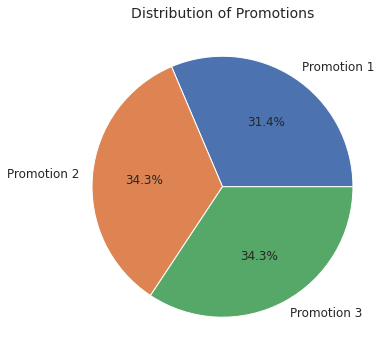

In [7]:
# Explore the distribution of promotion
sns.set_theme()
plt.figure(figsize=(6,6))
pie_labels = ['Promotion 1', 'Promotion 2', 'Promotion 3']
plt.pie(df.groupby(['Promotion']).size().to_list(), 
        labels=pie_labels, autopct='%1.1f%%',textprops={'fontsize': 12})
plt.title('Distribution of Promotions', fontsize=14)
plt.show()

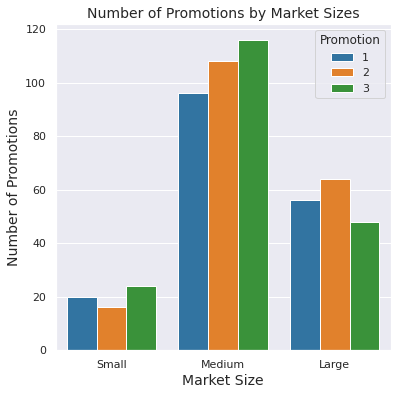

In [8]:
# Explore the promotion with different market sizes
df_bar = df.groupby(['Promotion','MarketSize']).size().to_frame().reset_index()
df_bar.rename({0:'NumOfStore'}, axis=1, inplace=True)

sns.set_theme()
plt.figure(figsize=(6,6))
ax = sns.barplot(x='MarketSize', y='NumOfStore',hue='Promotion', 
                 data=df_bar, hue_order=[1,2,3], palette='tab10', order=['Small', 'Medium','Large'])
# ax.set(xlabel='Promotion Type', ylabel='Number of Stores', fontsize=18)
plt.xlabel('Market Size', fontsize=14)
plt.ylabel('Number of Promotions', fontsize=14)
plt.legend(title='Promotion')
plt.title('Number of Promotions by Market Sizes', fontsize=14)
plt.show()

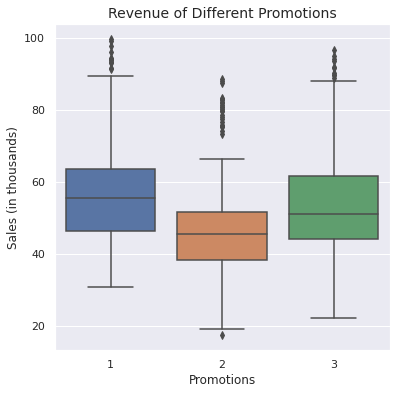

In [9]:
# Explore the sales with promotion and market sizes
fig= plt.figure(figsize=(6,6))
# ax = sns.displot(x="SalesInThousands", data=df, hue='MarketSize',
#                  col='Promotion', kind='kde', col_order=[1,2,3], hue_order=['Small','Medium','Large'])

ax = sns.boxplot(y="SalesInThousands", data=df, x='Promotion', 
                 order =[1,2,3])
ax.set_ylabel('Sales (in thousands)')
ax.set_xlabel('Promotions')
ax.set_title('Revenue of Different Promotions', fontsize=14)
plt.show()

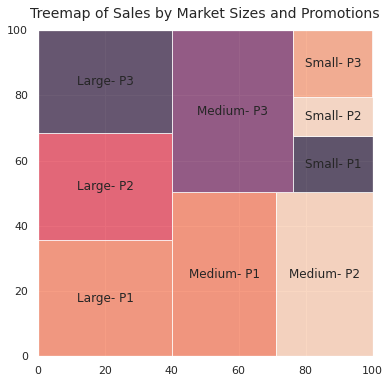

In [10]:
treemap = df.groupby(['MarketSize','Promotion'])['SalesInThousands'].sum().to_frame().reset_index()
treemap['Market-Promotion'] = treemap['MarketSize'].astype(str) + '- P' + treemap['Promotion'].astype(str)
fig = plt.figure(figsize=(6,6))
squarify.plot(sizes=treemap['SalesInThousands'], label=treemap['Market-Promotion'], alpha=.7)
plt.title("Treemap of Sales by Market Sizes and Promotions", fontsize =14, pad=12)
plt.show()

### ANOVA and Post Hoc Test <a class="anchor" id="chapter4"></a>

### All Types of Markets <a class="anchor" id="section_4_1"></a>

In [11]:
df.groupby('Promotion')['SalesInThousands'].mean()

Promotion
1    58.099012
2    47.329415
3    55.364468
Name: SalesInThousands, dtype: float64

In [12]:
p1_sale = df[df['Promotion'] == 1]['SalesInThousands']
p2_sale = df[df['Promotion'] == 2]['SalesInThousands']
p3_sale = df[df['Promotion'] == 3]['SalesInThousands']

In [13]:
stats.f_oneway(p1_sale, p2_sale, p3_sale)

F_onewayResult(statistic=21.953485793080677, pvalue=6.765849261408714e-10)

**Results from ANOVA test with all market sizes:**

The test output yields an F-statistic of 21.95, and the p-value is 6.766*10^-10, indicating a significant promotion effect on sales revenue. The p-value is significant at a 99% confidence level. 

Next, we will do a post-hoc test for each pair of promotions.

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.001,-14.774,-6.7652,True
1,3,-2.7345,0.2447,-6.7389,1.2698,False
2,3,8.0351,0.001,4.1207,11.9494,True


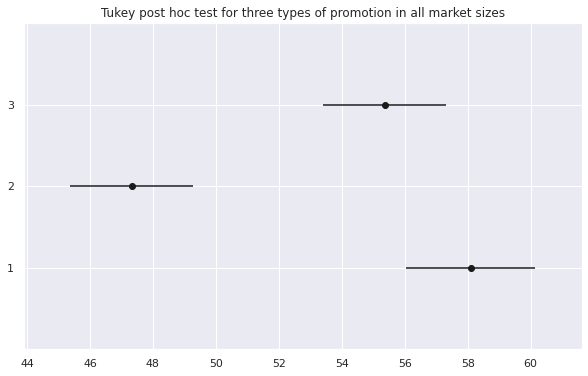

In [14]:
tukey = pairwise_tukeyhsd(endog=df['SalesInThousands'],     
                          groups=df['Promotion'],   
                          alpha=0.05)          

tukey.plot_simultaneous()    
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")
plt.title("Tukey post hoc test for three types of promotion in all market sizes")
tukey.summary()   

**Results from post-hoc Tukey test with all market sizes:**

The Tukey post hoc test indicates that there is a significant difference between promotion 2 and others. However, there is no difference between 1 and 3. 

Next, we would like to know if there is a specific promotion suitable for each market.


In [15]:
# Data preparation
df['market-promotion'] = df['MarketSize'].astype(str) + '-' + df['Promotion'].astype(str)
df.head(3)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,market-promotion
0,1,Medium,1,4,3,1,33.73,Medium-3
1,1,Medium,1,4,3,2,35.67,Medium-3
2,1,Medium,1,4,3,3,29.03,Medium-3


In [16]:
large1 = df.loc[(df['market-promotion']=='Large-1'), 'SalesInThousands']
large2 = df.loc[(df['market-promotion']=='Large-2'), 'SalesInThousands']
large3 = df.loc[(df['market-promotion']=='Large-3'), 'SalesInThousands']

medium1 = df.loc[(df['market-promotion']=='Medium-1'), 'SalesInThousands']
medium2 = df.loc[(df['market-promotion']=='Medium-2'), 'SalesInThousands']
medium3 = df.loc[(df['market-promotion']=='Medium-3'), 'SalesInThousands']

small1 = df.loc[(df['market-promotion']=='Small-1'), 'SalesInThousands']
small2 = df.loc[(df['market-promotion']=='Small-2'), 'SalesInThousands']
small3 = df.loc[(df['market-promotion']=='Small-3'), 'SalesInThousands']

### Small Market <a class="anchor" id="section_4_2"></a>

In [17]:
stats.f_oneway(small1, small2, small3)  

F_onewayResult(statistic=16.57648112557373, pvalue=2.115939995841426e-06)

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-9.3519,0.001,-13.6829,-5.0208,True
1,3,-0.6483,0.9,-4.5579,3.2612,False
2,3,8.7035,0.001,4.536,12.8711,True


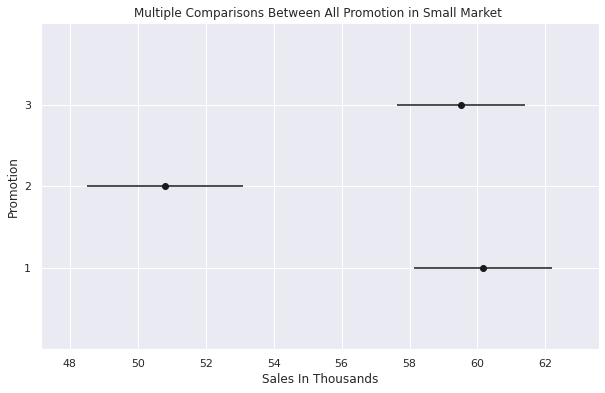

In [18]:
small = df.loc[df['MarketSize'] == 'Small', :]

tukey_small = pairwise_tukeyhsd(endog=small['SalesInThousands'],  
                          groups=small['Promotion'],   
                          alpha=0.05)  

tukey_small.plot_simultaneous()    
plt.title("Multiple Comparisons Between All Promotion in Small Market ")
plt.xlabel("Sales In Thousands")
plt.ylabel("Promotion")
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey_small.summary()

### Medium Market <a class="anchor" id="section_4_3"></a>

In [19]:
stats.f_oneway(medium1, medium2, medium3)  

F_onewayResult(statistic=29.68813375084531, pvalue=1.5197404971604578e-12)

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-8.5583,0.001,-11.3108,-5.8057,True
1,3,-2.2037,0.1356,-4.9113,0.5038,False
2,3,6.3545,0.001,3.7306,8.9785,True


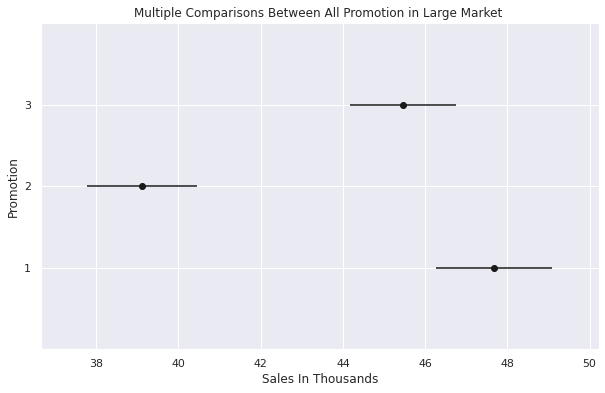

In [20]:
medium = df.loc[df['MarketSize'] == 'Medium', :]
tukey_medium = pairwise_tukeyhsd(endog=medium['SalesInThousands'],  
                          groups=medium['Promotion'],   
                          alpha=0.05)  

tukey_medium.plot_simultaneous()    
plt.title("Multiple Comparisons Between All Promotion in Large Market ")
plt.xlabel("Sales In Thousands")
plt.ylabel("Promotion")
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey_medium.summary()  

### Large Market <a class="anchor" id="section_4_4"></a>

In [21]:
stats.f_oneway(large1, large2, large3)  

F_onewayResult(statistic=21.44511115677835, pvalue=5.261567483455427e-09)

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-14.9139,0.001,-21.5284,-8.2993,True
1,3,1.9681,0.7701,-5.1424,9.0785,False
2,3,16.8819,0.001,9.9797,23.7842,True


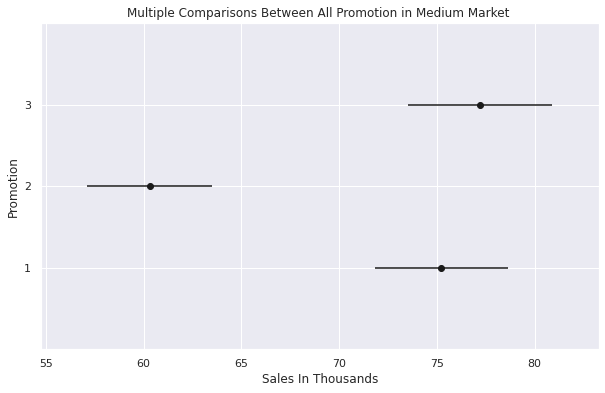

In [22]:
large = df.loc[df['MarketSize'] == 'Large', :]

tukey_large = pairwise_tukeyhsd(endog=large['SalesInThousands'],  
                          groups=large['Promotion'],   
                          alpha=0.05)  

tukey_large.plot_simultaneous()    
plt.title("Multiple Comparisons Between All Promotion in Medium Market ")
plt.xlabel("Sales In Thousands")
plt.ylabel("Promotion")
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey_large.summary() 

**Results from tests in small, medium and large market size:**

The results for promotions on large, medium and small market size yields the same results as the overall one. 

### Conclusion <a class="anchor" id="chapter5"></a>

The ANOVA and post hoc tests found that promotions 1 and 3 generate a higher mean revenue than promotion 2 in all types of markets. Thus, the company could consider using promotions 1 and 3 in their future market campaign. 